In [7]:
FILTER_STOP_WORDS = True
FILTER_BY_LENGTH = True
MIN_LENGTH = 30.0 #min
NORMALIZE_MATRIX_BY_LENGTH = True


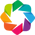

In [10]:
from __future__ import division
import string
import math
import os
import nltk
%matplotlib inline
import json
import unidecode
import numpy as np
import holoviews as hv
import pickle

hv.extension('bokeh')
import pandas as pd
from scipy import stats
from text_clustering import text_preprocessing as tp, word_connection_matrix as wcm,viz

In [2]:
root_path = 'C:\Users\CATALINA ESPINOZA\Documents\clusters ciae'
data_path = os.path.join(root_path,'data')
output_path = os.path.join(root_path,'output')
pickle_path = os.path.join(output_path,'pickles')
by_grade_path = os.path.join(output_path,'textos_ulloa_by_curso')
by_grade_and_content = os.path.join(data_path,'textos_ulloa_by_grade_content')
by_content_path = os.path.join(output_path,'textos_ulloa_by_contenido')
all_files_path = os.path.join(data_path,'textos_ulloa')
all_classes = os.path.join(data_path,'clases_ulloa.txt')

In [3]:
def to_tuple(matrix):
    a_tuple_list = []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            a_tuple_list.append((i,j,matrix[i,j]))
    return a_tuple_list

In [4]:
all_documents_dict = tp.read_documents(all_files_path)

In [5]:
len(all_documents_dict)

56

In [11]:
with open(os.path.join(output_path,'pickles','document_length_dict.pickle'),'rb') as f:
    document_length = pickle.load(f)

In [12]:
document_length_filtered = {}
if FILTER_BY_LENGTH:
    filtered_documents = {}
    for document in all_documents_dict.keys():
        if document_length[document]>= MIN_LENGTH:
            document_length_filtered[document] = document_length[document]
            filtered_documents[document] = all_documents_dict[document]
    all_documents_dict = filtered_documents

In [13]:
dict_by_grade_and_content = tp.get_dict_files_with_grade_and_content(by_grade_and_content)

In [14]:
def split_documents_in_acts(dict_doc,dict_length):
    documents_splitted = {}
    document_lengths = []
    for doc in dict_doc.keys():
        length = dict_length[doc]
        doc_text = dict_doc[doc].splitlines()
        n_lineas = len(doc_text)
        n_lineas_10_min = int((10*60)/5)# n lineas 10 min
        n_lineas_act = int((n_lineas - (n_lineas_10_min*2))/2)
        inicio = doc_text[:n_lineas_10_min] # primeros 10m
        act_I = doc_text[n_lineas_10_min:(n_lineas_act + n_lineas_10_min)]
        act_II = doc_text[(n_lineas_act + n_lineas_10_min):-n_lineas_10_min]
        descenlace = doc_text[-n_lineas_10_min:] # ultimos 10m
        documents_splitted[doc] = {'inicio':'\n'.join(inicio),'act_I':'\n'.join(act_I),'act_II':'\n'.join(act_II),'descenlace':'\n'.join(descenlace)}
        document_lengths.append(n_lineas_10_min)
        document_lengths.append(n_lineas_act)
        document_lengths.append(n_lineas_act)
        document_lengths.append(n_lineas_10_min)
        
    return documents_splitted,document_lengths

In [15]:
document_splitted,document_lengths = split_documents_in_acts(all_documents_dict,document_length_filtered)

In [16]:
def get_labels_and_splitted_documents(dict_labels,dict_doc):
    documents_separated = {}
    labels = []
    for doc in dict_doc.keys():
        etapas = ['inicio','act_I','act_II','descenlace']
        new_label = dict_labels[doc]['grade']+'_'+dict_labels[doc]['content']
        new_label = new_label.replace(' ','_')
        for i in range(len(etapas)):
            new_key = doc+'_'+etapas[i]
            documents_separated[new_key] = dict_doc[doc][etapas[i]]
            labels.append(new_key+'_'+new_label)
    return labels,documents_separated

In [17]:
labels,document_splitted = get_labels_and_splitted_documents(dict_by_grade_and_content,document_splitted)

In [18]:
d_lengths = {}
for count,a_key in enumerate(document_splitted.keys()):
    d_lengths[a_key] = document_lengths[count]
len(d_lengths)

204

## Leer tópicos desde archivo

In [20]:
topic_names = []
topic_words = []
topic_score = []
with open(os.path.join(data_path,'200_clusters.csv'), 'r') as f:
    first = True
    for line in f:
        if first:
            aux_list = line.split(';;')
            topic_names = map(lambda x: x.split(' ')[1],aux_list)
            first = False
        else:
            splited_line = line.split(';')
            topic_words.append(splited_line[::2])
            topic_score.append(splited_line[1::2])
n_topics = len(topic_names)
print n_topics

200


In [21]:
topic_words = np.matrix(topic_words).transpose().tolist()
topic_score = np.matrix(topic_score).transpose().tolist()

In [22]:
dict_topic_words = dict(zip(topic_names,topic_words))

In [23]:
flat_list = [item for sublist in topic_words for item in sublist]

In [25]:
set_of_topic_words = list(set(flat_list))
len(set_of_topic_words)

2820

In [26]:
dict_words_topics = {}
dict_words_topics_index = {}
for word in set_of_topic_words:
    dict_words_topics[word] = []
    dict_words_topics_index[word] = []
    for t in range(len(topic_words)):
        if word in topic_words[t]:
            dict_words_topics[word].append(topic_names[t])
            dict_words_topics_index[word].append(t)            

## Crear matriz de frecuencia de conectividad entre tópicos por clase

In [31]:
all_documents_dict = document_splitted

In [32]:
matrices_list,names_matrices = wcm.get_topic_matrices(all_documents_dict,dict_words_topics_index,n_topics)
print(len(matrices_list))

204


In [33]:
matrices_list[0].shape

(200L, 200L)

In [34]:
import datetime
datetime.datetime.now().time()

datetime.time(18, 3, 27, 546000)

In [35]:
wcm.check_symmetric(matrices_list[0]*matrices_list[0])

False

In [38]:
d_lengths

{'1491243046933_act_I': 193,
 '1491243046933_act_II': 110,
 '1491243046933_descenlace': 120,
 '1491243046933_inicio': 120,
 '1492455191238_act_I': 120,
 '1492455191238_act_II': 120,
 '1492455191238_descenlace': 218,
 '1492455191238_inicio': 86,
 '1492690427598_act_I': 110,
 '1492690427598_act_II': 120,
 '1492690427598_descenlace': 158,
 '1492690427598_inicio': 120,
 '1492699582441_act_I': 278,
 '1492699582441_act_II': 120,
 '1492699582441_descenlace': 120,
 '1492699582441_inicio': 120,
 '1493051693677_act_I': 120,
 '1493051693677_act_II': 229,
 '1493051693677_descenlace': 120,
 '1493051693677_inicio': 120,
 '1493060220051_act_I': 110,
 '1493060220051_act_II': 120,
 '1493060220051_descenlace': 316,
 '1493060220051_inicio': 120,
 '1493122799742_act_I': 120,
 '1493122799742_act_II': 120,
 '1493122799742_descenlace': 251,
 '1493122799742_inicio': 193,
 '1493128754967_act_I': 95,
 '1493128754967_act_II': 218,
 '1493128754967_descenlace': 323,
 '1493128754967_inicio': 316,
 '1493138205918_ac

In [41]:
norm_array_list = map(lambda x: np.ravel(x),wcm.normalize_matrices(matrices_list,d_lengths))
#norm_array_list = map(lambda x: np.ravel(x),norm_matrices_list)
#array_list = map(lambda x: np.ravel(x),matrices_list)

In [42]:
len(norm_array_list)

204

In [43]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt, mpld3
mpld3.enable_notebook()
import matplotlib.pylab as pylab

(array([ 28.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 176.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

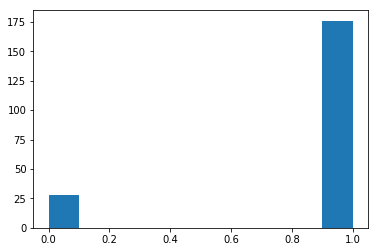

In [44]:
centers_kmeans,labels_kmeans = wcm.get_kmeans_clusters(norm_array_list,2)
plt.hist(labels_kmeans)

(array([ 22.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 182.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

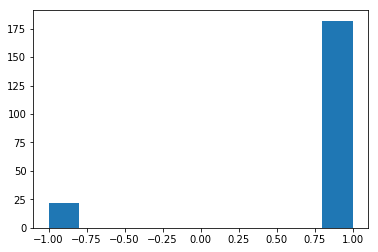

In [45]:
centers_svm,labels_svm = wcm.get_svm_clusters(norm_array_list)
plt.hist(labels_svm)

In [46]:
kmeans_axis = centers_kmeans[1] - centers_kmeans[0]
svm_axis = centers_svm[1] - centers_svm[0]
kmeans_indicator_matrices = map(lambda x: np.dot(x,kmeans_axis),norm_array_list) 
svm_indicator_matrices = map(lambda x: np.dot(x,svm_axis),norm_array_list)

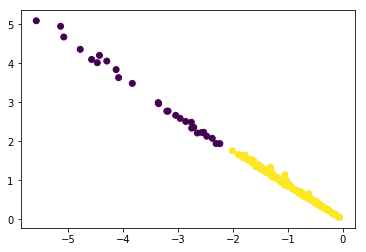

In [47]:
plt.scatter(kmeans_indicator_matrices,svm_indicator_matrices,c=labels_kmeans)

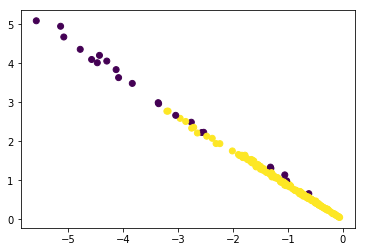

In [48]:
plt.scatter(kmeans_indicator_matrices,svm_indicator_matrices,c=labels_svm)

In [50]:
labels

[u'1493908207910_inicio_cuarto_psu_f\xedsica_(luz)',
 u'1493908207910_act_I_cuarto_psu_f\xedsica_(luz)',
 u'1493908207910_act_II_cuarto_psu_f\xedsica_(luz)',
 u'1493908207910_descenlace_cuarto_psu_f\xedsica_(luz)',
 u'1497445733276_inicio_cuarto_condensadores_y_magnetismo',
 u'1497445733276_act_I_cuarto_condensadores_y_magnetismo',
 u'1497445733276_act_II_cuarto_condensadores_y_magnetismo',
 u'1497445733276_descenlace_cuarto_condensadores_y_magnetismo',
 u'1497375275374_inicio_segundo_torque_y_palancas',
 u'1497375275374_act_I_segundo_torque_y_palancas',
 u'1497375275374_act_II_segundo_torque_y_palancas',
 u'1497375275374_descenlace_segundo_torque_y_palancas',
 u'1496173972733_inicio_octavo_energ\xeda_el\xe9ctrica',
 u'1496173972733_act_I_octavo_energ\xeda_el\xe9ctrica',
 u'1496173972733_act_II_octavo_energ\xeda_el\xe9ctrica',
 u'1496173972733_descenlace_octavo_energ\xeda_el\xe9ctrica',
 u'1493128754967_inicio_segundo_mrua_y_mrur',
 u'1493128754967_act_I_segundo_mrua_y_mrur',
 u'149312

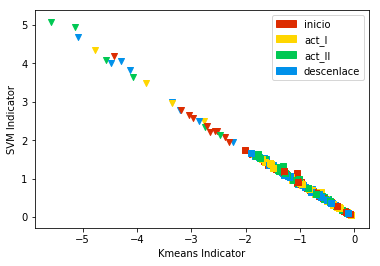

In [53]:
viz.scatter_plot_by_period_by_cluster(kmeans_indicator_matrices,svm_indicator_matrices,labels_kmeans,'Kmeans Indicator','SVM Indicator',labels,'upper right')

In [54]:
from text_clustering import viz

In [55]:
ks_matrix,w_ij_cluster0,w_ij_cluster1 = viz.get_ks_matrix(labels_kmeans,norm_array_list,topic_names)

In [56]:
%%opts HeatMap [tools=['hover'] colorbar=True width=1000 height=1000 toolbar='above']
heatmap = viz.ks_heatmap(ks_matrix,w_ij_cluster0,w_ij_cluster1,topic_names)
heatmap

:HeatMap   [x,y]   (KS,freq_in_documents_and_by_minute_cluster_0,freq_in_documents_and_by_minute_cluster_1)

In [59]:
set_all = topic_names
list_ks_sorted = np.argsort(np.ravel(ks_matrix))
sorted_pair_ij = wcm.get_word_pairs(list_ks_sorted,len(ks_matrix),len(set_all))
zipped_pair_ij = zip(sorted_pair_ij[0],sorted_pair_ij[1])
flipped = np.flip(sorted_pair_ij,0)
for i in range(len(flipped)):
    if i <20:
        print str(i)+") "+set_all[flipped[i][0]]+"->"+set_all[flipped[i][1]]+", ks: "+str(ks_matrix[flipped[i][0],flipped[i][1]])

0) medir->?, ks: 0.8603896103896104
1) aritmetica->electricidad, ks: 0.814935064935065
2) fisica->?, ks: 0.8133116883116883
3) tablas->aritmetica, ks: 0.8108766233766234
4) ?->aritmetica, ks: 0.8108766233766234
5) responder->aritmetica, ks: 0.8076298701298702
6) explicar->?, ks: 0.8060064935064934
7) electricidad->?, ks: 0.8051948051948052
8) tablas->electricidad, ks: 0.8011363636363636
9) division->aritmetica, ks: 0.7978896103896104
10) explicar->aritmetica, ks: 0.7978896103896104
11) electricidad->textos, ks: 0.7962662337662338
12) aritmetica->?, ks: 0.7930194805194805
13) aritmetica->cinematica, ks: 0.7905844155844156
14) algebra->electricidad, ks: 0.786525974025974
15) tablas->?, ks: 0.7849025974025975
16) industria->electricidad, ks: 0.7849025974025975
17) electricidad->ejercitar, ks: 0.7808441558441559
18) electricidad->industria, ks: 0.7775974025974026
19) responder->electricidad, ks: 0.7767857142857143


### KS matrix with filtered topics

In [60]:
selected_topics = ['vectores','problemas','ordenar','metodo','explicar','tablas','trabajo','ciencia','aprender','representar','responder','electricidad','hacer','operar','gases','evaluar','medio','atmosfera','esquema','ejercitar','atomo','agua','aire','energia','algebra','fisica','experimentar','razonar','astronomia','cinematica']

In [68]:
selected_words = []
selected_topics_names = []
for topic_index,topic in enumerate(topic_names):
    if topic in selected_topics:
        selected_words.append(filter(lambda x: True if len(x)>2 else False,topic_words[topic_index]))
        selected_topics_names.append(topic)

In [69]:
flat_list = [item for sublist in selected_words for item in sublist]
set_of_selected_topic_words = list(set(flat_list))
len(set_of_selected_topic_words)

710

In [70]:
dict_words_topics_filtered = {}
dict_words_topics_index_filtered = {}
for word in set_of_selected_topic_words:
    dict_words_topics_filtered[word] = []
    dict_words_topics_index_filtered[word] = []
    for t in range(len(selected_words)):
        if word in selected_words[t]:
            dict_words_topics_filtered[word].append(selected_topics_names[t])
            dict_words_topics_index_filtered[word].append(t)            

In [71]:
n_topics = len(selected_topics_names)
n_topics

48

In [73]:
matrices_list,names_matrices = wcm.get_topic_matrices(all_documents_dict,dict_words_topics_index_filtered,n_topics)
print(len(matrices_list))

204


In [72]:
len(all_documents_dict)

204

In [74]:
for i in range(len(selected_topics_names)):
    selected_topics_names[i] = selected_topics_names[i]+'_'+str(i)

In [75]:
%%opts HeatMap [tools=['hover'] colorbar=True width=1000 height=1000 toolbar='above']
is_1 = lambda x : 1 if x>0 else 0
freq_matrix = sum(matrices_list)
df = pd.DataFrame(freq_matrix)
df.columns = map(lambda x: x.replace(" ",""),selected_topics_names)
#df.index =  map(lambda x: x.replace(" ",""),selected_topics_names)
count_pair_c0 = map(lambda x: sum(map(is_1,x)),w_ij_cluster0)
count_pair_c1 = map(lambda x: sum(map(is_1,x)),w_ij_cluster1)
freq_pair_c0 = map(lambda x: sum(x),w_ij_cluster0)
freq_pair_c1 = map(lambda x: sum(x),w_ij_cluster1)

heatmap = hv.HeatMap(wcm.to_tuple(df,count_pair_c0,count_pair_c1,freq_pair_c0,freq_pair_c1),vdims=['pair frequency','freq_in_documents_and_by_minute_cluster_0','freq_in_documents_and_by_minute_cluster_1'])
heatmap

:HeatMap   [x,y]   (pair frequency,freq_in_documents_and_by_minute_cluster_0,freq_in_documents_and_by_minute_cluster_1)

In [80]:
n_kmeans = 2
clusters_max = [0,1]
# filtrar documentos con palabras
if NORMALIZE_MATRIX_BY_LENGTH:
    norm_matrices_list = wcm.normalize_matrices(matrices_list,d_lengths)
else:
    norm_matrices_list = matrices_list

In [84]:
norm_array_list = map(lambda x: np.ravel(x),norm_matrices_list)
# sacar otros indicadores
centers_kmeans,labels_kmeans_topics = wcm.get_kmeans_clusters(norm_array_list,n_kmeans)
kmeans_axis = centers_kmeans[clusters_max[0]] - centers_kmeans[clusters_max[1]]
topics_indicator = map(lambda x: np.dot(x,kmeans_axis),norm_array_list) 

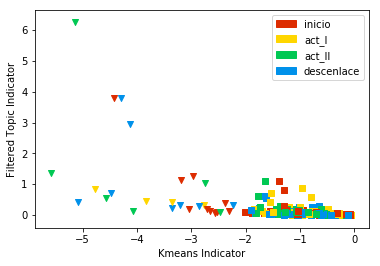

In [87]:
viz.scatter_plot_by_period_by_cluster(kmeans_indicator_matrices,topics_indicator,labels_kmeans,'Kmeans Indicator','Filtered Topic Indicator',labels,'upper right')

In [107]:
len(norm_array_list)

204

In [88]:
%%opts HeatMap [tools=['hover'] colorbar=True width=1000 height=1000 toolbar='above']
ks_matrix,w_ij_cluster0,w_ij_cluster1 = viz.get_ks_matrix(labels_kmeans,norm_array_list,selected_topics_names)
heatmap = viz.ks_heatmap(ks_matrix,w_ij_cluster0,w_ij_cluster1,selected_topics_names)
heatmap

:HeatMap   [x,y]   (KS,freq_in_documents_and_by_minute_cluster_0,freq_in_documents_and_by_minute_cluster_1)

In [102]:
len(selected_topics)

30

In [105]:
list_ks_sorted = np.argsort(np.ravel(ks_matrix))
sorted_pair_ij = wcm.get_word_pairs(list_ks_sorted,len(ks_matrix),len(ks_matrix))
zipped_pair_ij = zip(sorted_pair_ij[0],sorted_pair_ij[1])
flipped = np.flip(sorted_pair_ij,0)
for i in range(len(flipped)):
    if i <20:
        print str(i)+") "+selected_topics_names[flipped[i][0]]+"->"+selected_topics_names[flipped[i][1]]+", ks: "+str(round(ks_matrix[flipped[i][0],flipped[i][1]],2))

0) cinematica_47->ejercitar_22, ks: 0.69
1) electricidad_13->energia_37, ks: 0.66
2) fisica_33->energia_37, ks: 0.66
3) electricidad_13->vectores_0, ks: 0.65
4) trabajo_8->electricidad_13, ks: 0.65
5) evaluar_35->explicar_6, ks: 0.64
6) cinematica_47->electricidad_13, ks: 0.64
7) fisica_33->cinematica_47, ks: 0.63
8) electricidad_13->cinematica_47, ks: 0.63
9) fisica_33->explicar_6, ks: 0.62
10) explicar_40->electricidad_13, ks: 0.62
11) responder_42->cinematica_47, ks: 0.62
12) electricidad_13->ejercitar_22, ks: 0.61
13) explicar_6->electricidad_13, ks: 0.61
14) cinematica_47->explicar_6, ks: 0.6
15) trabajo_8->cinematica_47, ks: 0.6
16) explicar_6->cinematica_47, ks: 0.6
17) fisica_33->ejercitar_22, ks: 0.6
18) explicar_6->ejercitar_22, ks: 0.59
19) energia_37->cinematica_47, ks: 0.59


In [104]:
# TODO: revisar si las palabras que componen los tópicos están bien

In [116]:
[i for i in range(len(topic_names)) if topic_names[i]=='explicar' ]

[25, 54, 166]

In [125]:
[str(t) for t in topic_words[25]]

['puedes',
 'usa',
 'c\xc3\xb3mo',
 'escribe',
 'cada',
 'explica',
 'usar',
 'papel',
 'hacer',
 'aprendo',
 'objetivo',
 'represen',
 'dibujo',
 'haz',
 'escribir',
 'ejemplo',
 'comprueb',
 'dibuja',
 'atenci\xc3\xb3n',
 'hago']